In [1]:

# Sys imports
import json
import os
import sys
from tqdm import tqdm

os.environ["KERAS_BACKEND"] = "jax"

# Training API
import keras as keras
from keras import layers
import keras_nlp

# Data manipulation
import numpy as np

# Data visualization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import jax.numpy as jnp




2024-03-21 08:24:29.868614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 08:24:29.868650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 08:24:29.869695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 08:24:31.141671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# DATA LOADER 
def parse_jsonl_optimized(filepath, num_lines_to_import=None):
    titles = []
    view_counts = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for i, line in enumerate(tqdm(file, desc="Processing")):
            # Check if the specified number of lines has been reached (if specified)
            if num_lines_to_import is not None and i >= num_lines_to_import:
                break
            # Parse the current line
            data = json.loads(line)
            # Extract and store the title and view count
            titles.append(data['title'])
            view_counts.append(data['view_count'])
    return titles, view_counts

# Example usage: Import only the first 1000 lines from the file
file_path = '/mnt/datassd/train_data.jsonl'
num_lines_to_import = 2  # You can adjust this number as needed
titles, view_counts = parse_jsonl_optimized(file_path, num_lines_to_import)

Processing: 2it [00:00, 8264.64it/s]

{'title': 'ЛИЦО, КАК ЛИЦО - ВЫБИЛ ФРЭНКА! НАРЕЗКА СО СТРИМА #8', 'view_count': 52193}
{'title': 'АВТОАТАКА МОЯ ЖИЗНЬ! Я ДОНАТЕР - МНЕ ПРОСТИТЕЛЬНО! НАРЕЗКА СО СТРИМА #7', 'view_count': 46523}


In [3]:
y_view_count = np.where(np.log(view_counts) == -np.inf, 0, np.log(view_counts))

from transformers import AutoTokenizer

# Load a pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Example titles
titles_test = titles[:1000000]

#tokenized_titles = [tokenizer.tokenize(title_test) for title_test in tqdm(titles_test, total=len(titles_test), desc="Tokenizing")]

encoded_inputs = [tokenizer.encode(title_test, add_special_tokens=True) for title_test in tqdm(titles_test, total=len(titles_test), desc="Encoding")]


/tmp/ipykernel_18980/2942887025.py:1: RuntimeWarning: divide by zero encountered in log
  y_view_count = np.where(np.log(view_counts) == -np.inf, 0, np.log(view_counts))
Encoding: 100%|█| 100000/100000 [00:07<00:00, 13665.3


In [4]:
# Testing cased inputs in tokenization

titulos_raros = [r'IS THIS TOKEN Cased?']

print(tokenizer.tokenize(titulos_raros[0]))

tokenizer.encode(titulos_raros[0], add_special_tokens=True)


['IS', 'T', '##H', '##IS', 'TO', '##KE', '##N', 'Case', '##d', '?']


[101, 19432, 157, 3048, 6258, 16972, 22441, 2249, 9060, 1181, 136, 102]

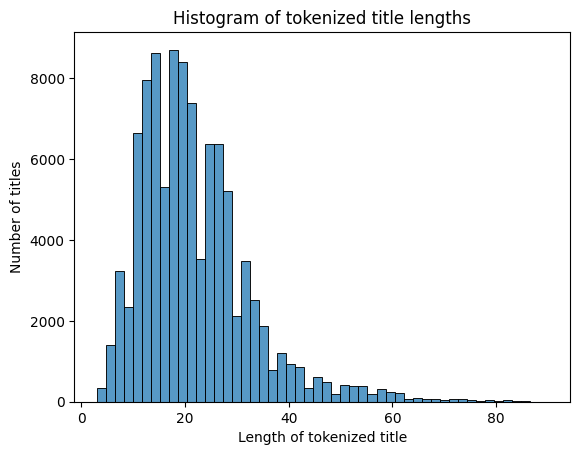

In [5]:
# Histogram on len(encoded_inputs)
sns.histplot([len(encoded_input) for encoded_input in encoded_inputs], bins=50)
plt.title("Histogram of tokenized title lengths")
plt.xlabel("Length of tokenized title")
plt.ylabel("Number of titles")
plt.show()

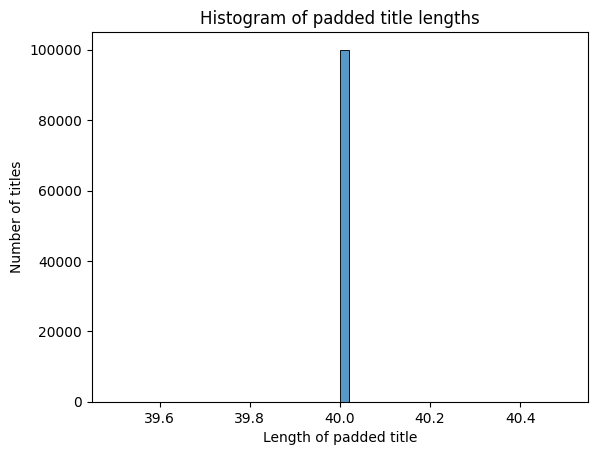

In [6]:
# Define model architecture
vocab_size = 30522  # Adjusted to match BERT's vocabulary size for bert-base-cased
embedding_dim = 256
max_length = 40  # Ensure your data is adjusted accordingly
num_heads = 4
intermediate_dim = 512
num_encoder_layers = 4

padded_inputs = pad_sequences(encoded_inputs, maxlen=max_length, padding='post', truncating='post')

# Just making sure, some EDA on padded inputs
sns.histplot([len(padded_input) for padded_input in padded_inputs], bins=50)
plt.title("Histogram of padded title lengths")
plt.xlabel("Length of padded title")
plt.ylabel("Number of titles")
plt.show()

In [7]:
sample = [tokenizer.decode(padded_input) for padded_input in padded_inputs[90:100]]
sample

['[CLS] Sigala - Brighter Days ft. Paul Janeway of St. Paul & The Broken Bones [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Sigala - What You Waiting For ( Lyrics ) ft. Kylie Minogue [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Sikdope - Lost In The Blue Feat. Nevve [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Smiie - Fool ( Official Music Audio ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Lauv - Superhero ( Moilatch Remix ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [8]:
X = jnp.array(padded_inputs)
Y = jnp.array(y_view_count)

inputs = keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size, 
    sequence_length=max_length, 
    embedding_dim=embedding_dim,
)

x = embedding_layer(inputs)

for _ in range(num_encoder_layers):
    encoder = keras_nlp.layers.TransformerEncoder(
        num_heads=num_heads,
        intermediate_dim=intermediate_dim,
        activation='selu',
        dropout=0.1,
    )
    x = encoder(x)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='selu')(x)
outputs = layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 40, 256)        │     7,823,872 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,998,337 (38.14 MB)

 Trainable params: 9,998,337 (38.14 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training loop
model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.2)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 73.5121 - val_loss: 82.7004
